# The Simplest Example Usage of `edges-analysis`

In this memo, I run all four levels of `edges-analysis` as an example of how to use it, and the results it gives by default. It is not meant to produce the "best" output data, just an example set.

Even though I am working in a notebook, I will use the CLI to actually produce the datasets, as that is more likely what we will do regularly. Nevertheless, the results of the CLI commands can still be read directly into Python to make plots etc., which we will do here. All cells that begin with a "!" are executed in the shell.

### Imports and Such

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from edges_analysis import levels, config
from edges_cal import CalibrationObservation

import numpy as np

## Configuration

The `config` object that we imported contains all the configuration values for the run. These are set globally, so modifying them now will mean that the rest of the notebook will use them. 

The settings that are most useful are the "paths", which specify default locations of certain kinds of input and output files. This makes it easy to have a given filesystem layout one one computer, and another layout on another. You can make your configuration permanent by using the `config.write` method.

Here's the configured paths we're using:

In [4]:
config.config['paths']

{'antenna': '/home/smurray/edges-antenna-meta',
 'beams': '/home/smurray/edges-beams',
 'field_products': '/home/smurray/edges/steven-level-cache',
 'lab_products': '/home/smurray/edges/steven-calibration-cache',
 'raw_field_data': '/data5/edges/data/2014_February_Boolardy',
 'raw_lab_data': '/data4/edges/data/CalibrationObservations',
 'sky_models': '/home/smurray/data4/edges-sky-models/'}

From this, it is clear that we're on the `enterprise` machine at ASU, which is where the raw data from EDGES is hosted. In principle, if you were to download some of the raw data to your own machine, you could set these paths appropriately. 

## Step 0: Generating Calibration Solutions

The first Level uses pre-made calibration solutions. You can create these solutions using `edges_cal`. In this example, we'll be running the pipeline on 2020 mid-band data, which uses Reciever 1. Thus, we use the last "good" solutions, from Nov 2019 (see [memo #160](http://loco.lab.asu.edu/loco-memos/edges_reports/Report-160.pdf) for details of some of the parameters):

In [2]:
calobs = CalibrationObservation(
    "/data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz", 
    f_low=40, f_high=200, cterms=12, wterms=12,
    s11_kwargs = {"resistance": 50.17},  # Male Maury standard applies to all loads
    resistance_f=50.0045  # Femail standard for LNA
)

Checking root folder: /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C
Checking S11 folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/S11
Checking Spectra folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Spectra
Checking Resistances folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Resistance
Checking Spectra folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Spectra
Checking Resistances folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/Resistance
Checking S11 folder contents at /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C/S11


Then we can write out a single "Calibration" file that will encapsulate the full calibration solution:

In [3]:
calobs.write("/home/smurray/data4/temporary_calibration_2019_11.h5")

/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:197: LinAlgWarning: Ill-conditioned matrix (rcond=1.59737e-17): result may not be accurate.
  return sp.linalg.solve(r, np.dot(q.T, Wydata)).flatten()
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:197: LinAlgWarning: Ill-conditioned matrix (rcond=7.98352e-18): result may not be accurate.
  return sp.linalg.solve(r, np.dot(q.T, Wydata)).flatten()
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:197: LinAlgWarning: Ill-conditioned matrix (rcond=4.01019e-44): result may not be accurate.
  return sp.linalg.solve(r, np.dot(q.T, Wydata)).flatten()


We can use the `calobs` object to make some diagnostic plots as well:

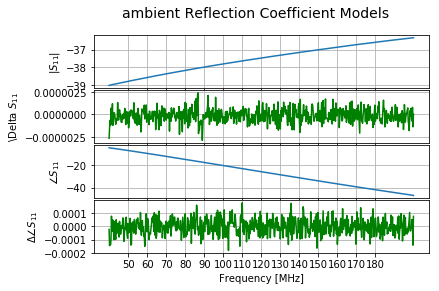

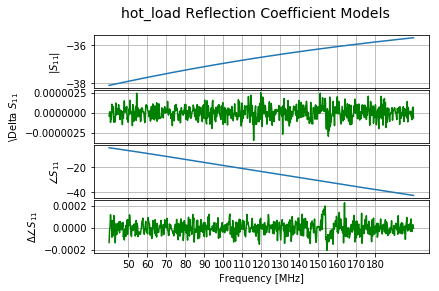

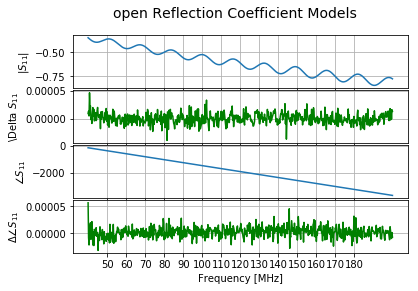

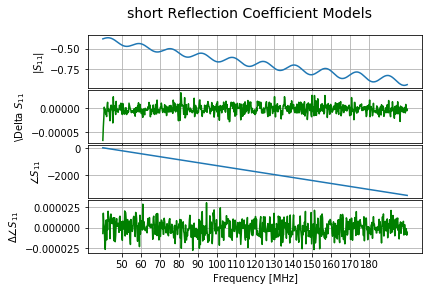

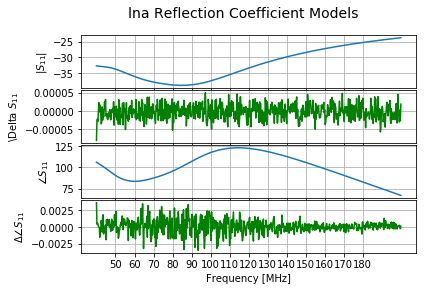

In [4]:
calobs.plot_s11_models();

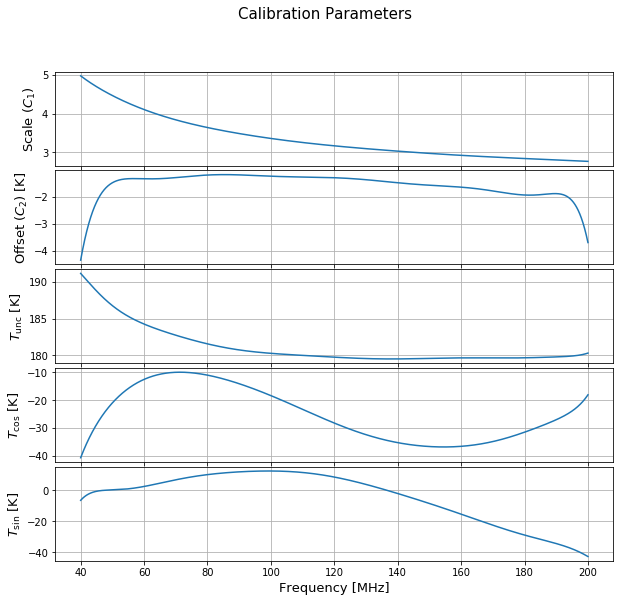

In [5]:
calobs.plot_coefficients();

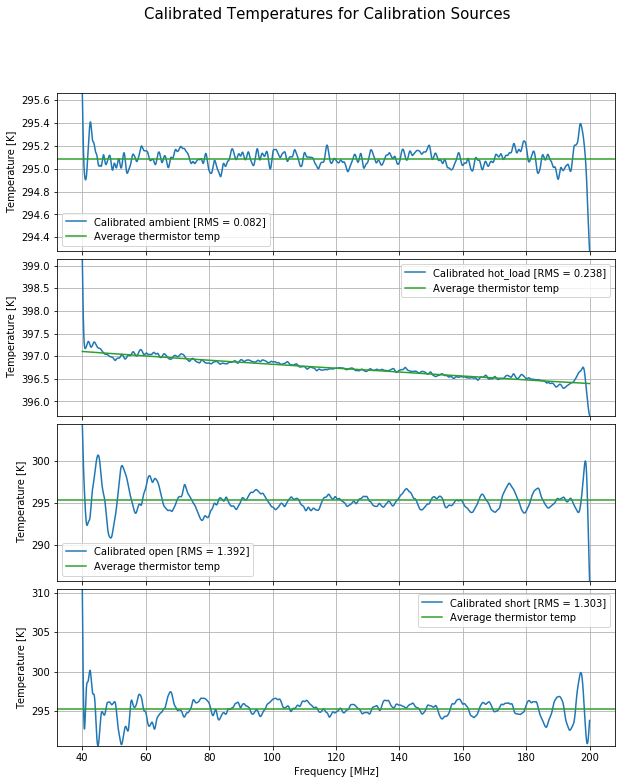

In [6]:
calobs.plot_calibrated_temps();

Clearly there is some level of oscillation in the calibrated solutions, but for our purposes here we are happy enough.

## Level1: Calibration

The first step of analysis is essentially to calibrate the field data. We do this reading in a number of files, and applying the above calibration solutions to them. The settings for this are defined in a YAML file:

In [2]:
!cat config/level1.yaml

band: mid
calfile: ~/data4/temporary_calibration_2019_11.h5
s11_path: ':daily'
balun_correction: false
antenna_correction: false
ground_correction: false
ignore_s11_files:
  - '2020_06'
  - '2020_070'
  - '2020_071'
  - '2020_072'


Let's quickly go through these settings. The `band` option is obvious. This needs to be set explicitly as there's no unambiguous way to tell from the files that are read which band it is (actually, I've noticed that this is not the case -- there's an 'instrument' meta key in the ACQ files. I will update that shortly.). The `calfile` setting points to the file we just create in Level 0.  `s11_path` points to where the S11 measurements are. By default, it tries to prepend the known location of field S11 files for the given band:

In [21]:
config.config['paths']['raw_field_data'] +f'/mro/mid/s11'

'/data5/edges/data/2014_February_Boolardy/mro/mid/s11'

And then searches in that directory for the file that is closest in date/time to each observation -- except that it ignores any files containing any of the patterns in `ignore_s11_files`. We could have specified an absolute path if we wanted to point it somewhere else for the files, and we could give it a full path to a specific file, rather than let it search within a directory for the closest matching one.

The other three settings are to correct for various chromatic effects. We leave them all off for this simple run, though they should by default be set to `true` (they are not all implemented properly yet).

Then, to run the calibration we use

In [ ]:
!edges-analysis calibrate config/level1.yaml 2020/2020_057* 2020/2020_058* 2020/2020_06* 2020/2020_070* 2020/2020_071* 2020/2020_072* 2020/2020_073* 2020/2020_074* 2020/2020_079* 2020/2020_08* 2020/2020_09* -m "Simplest possible calibration from Nov 2019"

Here, the first argument is `calibrate`, which is the command to apply. The second argument is the settings file we just looked at. The next list of arguments is a list of files to calibrate. In each case, the files are again prepended by the known location of raw field data (if that is setup in your `config`). Each is a glob-style string which will be expanded. Here, we follow Raul's [memo #175](http://loco.lab.asu.edu/loco-memos/edges_reports/EDGES_Memo_175.pdf) and use days 57-97 except for days 75-78.

Finall, the last argument (`-m`) gives a short message giving a description of this particular calibration (or a reason for it). This can be useful later on when you can't remember why you ran something in a particular way.

We can then read in these objects using the `Level1` class in Python:

In [27]:
l1 = levels.Level1("/home/smurray/edges/steven-level-cache/level1/c6e9a97917c96bdaa566322516d30607/2020_057_00_00_19.h5")

In [4]:
l1.meta['s11_files']

'/data5/edges/data/2014_February_Boolardy/mro/mid/s11/daily/2020_073_23_10_01_input1.s1p:/data5/edges/data/2014_February_Boolardy/mro/mid/s11/daily/2020_073_23_10_01_input2.s1p:/data5/edges/data/2014_February_Boolardy/mro/mid/s11/daily/2020_073_23_10_01_input3.s1p:/data5/edges/data/2014_February_Boolardy/mro/mid/s11/daily/2020_073_23_10_01_input4.s1p'

The directory the outputs were saved in is defined in your config:

In [89]:
config.config['paths']['field_products']

'/home/smurray/edges/steven-level-cache'

And each file in there is named based on its observation date. The actual settings used are also put into that folder, as well as a `README.txt` holding the message you passed when creating the files.

Every `Level` has some of the same attributes. You can get the calibrated temperature using `.spectrum`:

In [90]:
l1.spectrum.shape

(2560, 16384)

Sometimes there are more "spectrum-like" data in the object, which you can get from `.spectra`:

In [91]:
l1.spectra['Q'].shape

(2560, 16384)

Though `spectra` looks like a dictionary, it is _not_ one: it lazy-loads its data from the HDF5 file (then caches it in memory once it's read). You can see which keys will be there by looking at

In [92]:
l1._structure

{'frequency': None,
 'spectra': {'weights': None,
  'spectrum': None,
  'Q': None,
  'switch_powers': None},
 'ancillary': None,
 'meta': None}

We also have access to the metadata used to define this object:

In [5]:
for key, val in l1.meta.items():
    print(f"{key:<24}: {val}")

acquisition_rate        : 400
antenna_correction      : False
antenna_s11_n_terms     : 15
balun_correction        : False
band                    : mid
beam_file               : 
calfile                 : /home/smurray/data4/temporary_calibration_2019_11.h5
calobs_path             : /data5/edges/data/CalibrationObservations/Receiver01_2019_11_26_040_to_200MHz/25C
cterms                  : 12
datadir                 : /home/loco/edges/data
day                     : 57
edges_analysis_version  : 0.0.post0.dev1+gccaabb7
f_high                  : 150
f_low                   : 50
freq_max                : 200.0
freq_min                : 0.0
freq_res                : 0.006104
ground_correction       : False
help                    : 0
hide                    : 0
hour                    : 0
inifile                 : ./fastspec.ini
input_channel           : 1
instrument              : mid
kill                    : 0
n_file_lines            : 15389
n_poly_xrfi             : 7
nblk              

We can make some plots using the object:

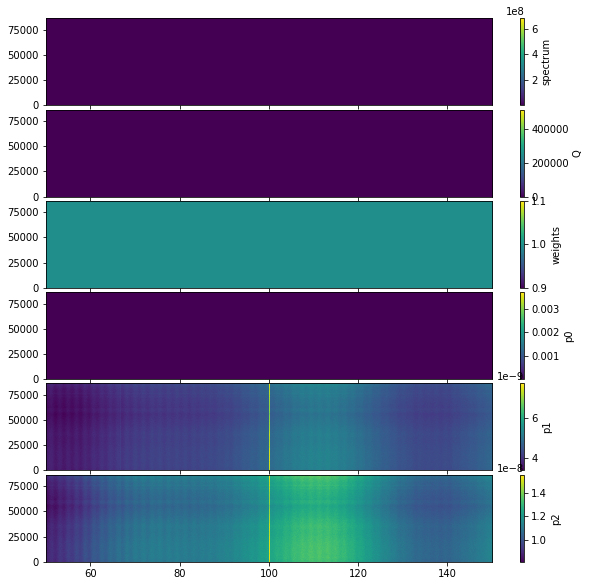

In [6]:
l1.plot_waterfalls();

These plots aren't very illuminating because the RFI blows the other parts out of the water. We can also plot time-averaged quantities:

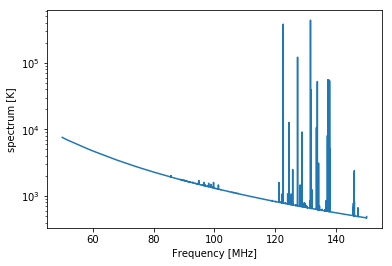

In [7]:
l1.plot_time_averaged_spectrum();

Lots of RFI, because we didn't do any RFI excision at this step.

We can also make simple S11 plots:

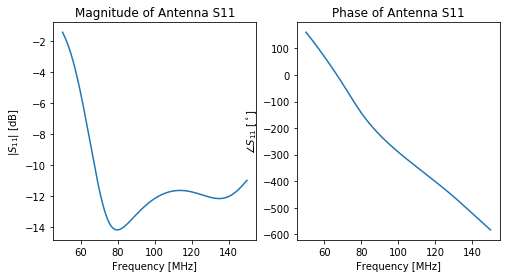

In [29]:
l1.plot_s11();

Finally, note that the original `Calibration` object can be accessed from the `Level1` object like so:

In [55]:
_calobs = l1.calibration

In [59]:
_calobs.C1_poly

poly1d([-0.86889539,  0.32693877,  2.40197182, -0.79914059, -2.50698419,
        0.80573637,  0.97483497, -0.05839892, -0.47786069,  0.43076836,
       -0.63141287,  3.16448265])

## Level2: combining, GHA binning, and flagging

In a similar way, we can produce a Level 2 object. We look at the settings file:

In [5]:
!cat config/level2.yaml

gha_bin_size: 0.5
sun_el_max: 90
moon_el_max: 90
ambient_humidity_max: 40
min_receiver_temp: 0
max_receiver_temp: 100
rms_filter_file: null
do_total_power_filter: false
xrfi_pipe:
  xrfi_poly:
    n_signal: 4
    n_resid: -1
    threshold: 10
    max_iter: 20
    increase_order: true
    decrement_threshold: 1
    min_threshold: 3


The new and interesting things here are all the filtering options, as well as the GHA bin size (which we set to half an hour). The `xrfi_pipe` is also interesting: it can hold a number of algorithms meant to be applied one after the other. We won't go into detail here.

To run:

In [ ]:
!edges-analysis level 2 config/level2.yaml -L config/level2.yaml

The new things here are the specification of the level we are trying to bump up to, and the `-L` argument. Here we point this to the previous settings file. This is able to automatically determine the location of the previously output files to input to this level. You could also point it to a particular filename(s).

The output filename will be writtent to stdout (I pre-ran it in this case so you can't see it here).

Reading this in:

In [6]:
l2 = levels.Level2("/home/smurray/edges/steven-level-cache/level2/f3c7a09ec5a28011bdc4bdc6a059436f/99138f534b5d500cdfc4f1781239987d.h5")

In [30]:
l2.spectrum.shape

(67, 48, 16384)

Here we have 67 files, 48 GHA bins, and 16384 frequency channels.

Text(0.5, 0, 'Frequency [MHz]')

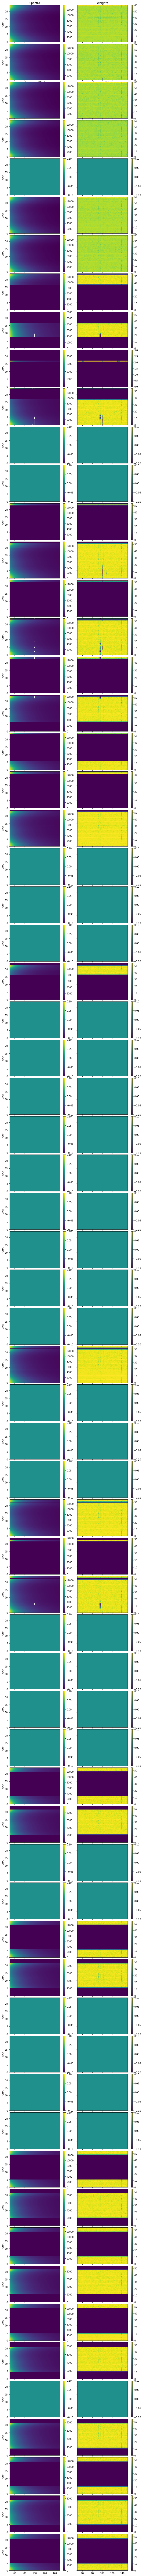

In [74]:
fig, ax = plt.subplots(len(l2.spectrum), 2, figsize=(10, 3*len(l2.spectrum)), sharex=True, sharey=True, 
                       gridspec_kw={"hspace": 0.05,'wspace': 0.075})

extent = (l2.raw_frequencies.min(), l2.raw_frequencies.max(), 0, 24)

for i, spec in enumerate(l2.spectrum):
    img = ax[i, 0].imshow(spec, aspect='auto', extent=extent)
    plt.colorbar(img, ax=ax[i, 0])
    ax[i, 0].set_ylabel("GHA")

for i, spec in enumerate(l2.weights):
    img = ax[i, 1].imshow(spec, aspect='auto', extent=extent)
    plt.colorbar(img, ax=ax[i,1])

ax[0, 0].set_title("Spectra")
ax[0, 1].set_title("Weights")

ax[-1, 0].set_xlabel("Frequency [MHz]")
ax[-1, 1].set_xlabel("Frequency [MHz]")


We can see that most bins still have quite a bit of weight. We can look at some averaged spectra as well:

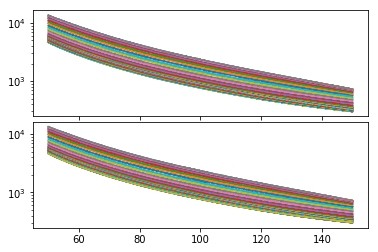

In [28]:
fig, ax = plt.subplots(len(l2.spectrum), 1, sharex=True, sharey=True, gridspec_kw={"hspace": 0.05})

for i, (spec, weights) in enumerate(zip(l2.spectrum, l2.weights)):
    
    for j, (s, w) in enumerate(zip(spec, weights)):
        ax[i].plot(l2.raw_frequencies[w>0], s[w>0])
        
    ax[i].set_yscale('log')

Actually, this seems reasonably good -- the obvious RFI has at least been extracted.

## Level3: Average over days

The settings:

In [8]:
!cat config/level3.yaml

# The simplest settings for level3 mean we just average over days without explicitly
# doing any more filtering (or any averaging over frequency)
day_range: null
ignore_days: null
f_low: null
f_high: null
freq_resolution: null
gha_filter_file: null


The Call:

In [11]:
!edges-analysis level 3 config/level3.yaml -L config/level2.yaml -i 99138f* --clobber

Settings:
    day_range: None
    ignore_days: None
    f_low: None
    f_high: None
    freq_resolution: None
    gha_filter_file: None
Using auto-generated label:  f3c7a09ec5a28011bdc4bdc6a059436f
Processing 99138f534b5d500cdfc4f1781239987d.h5
Output File: /home/smurray/edges/steven-level-cache/level3/d8ad2f48683103df73bbe0ff42293ffd/99138f534b5d500cdfc4f1781239987d.h5


There is a new option here in the call. While we have pointed at the correct `Level2` directory by using the `-L` option (which, again, uses the settings to get the default hash and find the directory), that directory potentially contains more than one file -- perhaps we ran `Level2` for different combinations of `Level1` files using the same settings. Since `Level3` takes only one `Level2` file, we need to specify the file more specifically. The `-i` option gives an input file, or a glob pattern that will expand to a single file. If only this option is given, then it must be a full absolute path. Combined with `-L`, it can be just the unique start of a filename within that directory, as we have provided here.

In [12]:
l3 = levels.Level3("/home/smurray/edges/steven-level-cache/level3/d8ad2f48683103df73bbe0ff42293ffd/99138f534b5d500cdfc4f1781239987d.h5")

In [13]:
l3.spectrum.shape

(48, 16384)

Here we see that the first axis from `Level2` has been averaged over (i.e. the files, or days). Beyond this, `Level3` also offers the possibility to perform further xRFI on GHA-binned data, to filter out specific days, to restrict the frequency range, and to average down in frequency (there's another chance to do these last two in the next step).

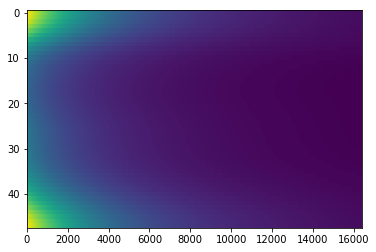

In [15]:
plt.imshow(l3.spectrum,aspect='auto')

We can plot it as a joy-division plot also:

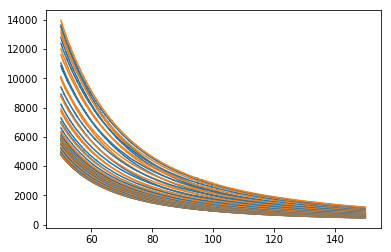

In [16]:
for i, spec in enumerate(l3.spectrum):
    plt.plot(l3.raw_frequencies, spec + 10*i, color=f"C{i%2}")

## Level4: averaged spectrum

The settings:

In [17]:
!cat config/level4.yaml

f_low: 60.0
f_high: 120.0
ignore_freq_ranges: null
freq_resolution: 0.5


In [18]:
!edges-analysis level 4 config/level4.yaml -L config/level3.yaml -i 99138f* --clobber

Settings:
    f_low: 60.0
    f_high: 120.0
    ignore_freq_ranges: None
    freq_resolution: 0.5
Using auto-generated label:  d8ad2f48683103df73bbe0ff42293ffd
Processing 99138f534b5d500cdfc4f1781239987d.h5
Output File: /home/smurray/edges/steven-level-cache/level4/a52c00cf2eb5cfd5882f3af39ce3290d/99138f534b5d500cdfc4f1781239987d.h5


In [19]:
l4 = levels.Level4("/home/smurray/edges/steven-level-cache/level4/a52c00cf2eb5cfd5882f3af39ce3290d/99138f534b5d500cdfc4f1781239987d.h5")

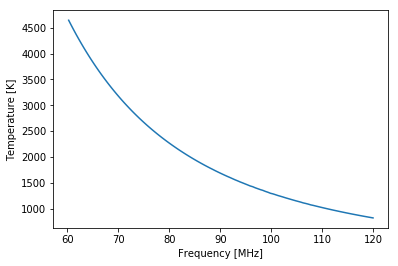

In [26]:
plt.plot(l4.raw_frequencies, l4.spectrum);
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]");

## Simplest Model Fit

From here, the spectrum should be fit with robust routines such as `polychord` (via routines in `edges-estimate`). However, we can do a very simple polynomial fit using tools directly in `edges-cal`:

In [21]:
from edges_cal.modelling import ModelFit

In [22]:
mask = ~np.isnan(l4.spectrum)

fit = ModelFit('PhysicalLin', l4.raw_frequencies[mask], l4.spectrum[mask], weights=l4.weights[mask], n_terms=5)

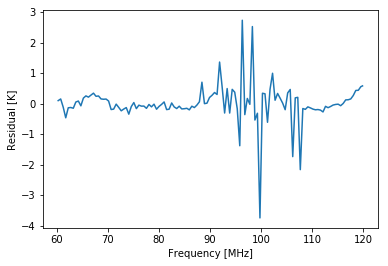

In [25]:
plt.plot(fit.xdata, fit.residual)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Residual [K]");

We clearly see that from 90-110 MHz, the RFI is strong, and has meant we can't get a very good fit.